In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import cma

# Initialization

In [2]:
n_photons = 50
vacuum_state = np.zeros(n_photons)
vacuum_state[0] = 1.

# from vacuum state to displaced squeezed state
coh_dis = [0.5, 0.2, 0.3, 0.3] # squeezed r*np.exp(i*phi)  and coherent |alpha|*np.exp(i*args(alpha))
gate2 = S_gate(coh_dis[0], coh_dis[1], n_photons) 
gate3 = D_gate(coh_dis[2], coh_dis[3], n_photons)

state_ = np.einsum('jk,k->j', gate2, vacuum_state)
initial_state = np.einsum('jk,k->j', gate3, state_)

# Configurations of possible gates

In [3]:
# conf1
simple_block = {'one_param':[V_gate, R_gate, V_gate], 'two_params':[S_gate, D_gate, S_gate], 'num_params':9}

# Configurations of Hamiltonians

In [4]:
# Hamiltonians 
"""
x,p  polynoms <= 6 degree
"""
ham = np.array([[0.,0.,1.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [1.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                ])

Initial_state


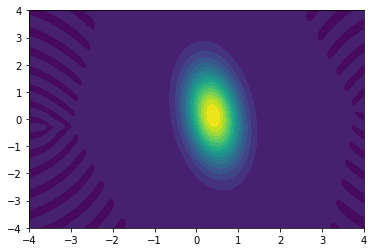

In [5]:
print("Initial_state")
init_state = initial_state.reshape(initial_state.shape[0],1)
rho = np.kron(init_state,init_state.conj().T)
xvec = np.linspace(-4,4,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [6]:
def circuit(state, params, simple_block, n_photons):
    
    number_of_single_params = len(simple_block['one_param'])
    
    for ind, gate in enumerate(simple_block['one_param']):
        state = np.einsum('jk,k->j', gate(params[ind],n_photons), state)
        
    for ind, gate in enumerate(simple_block['two_params']):
        state = np.einsum('jk,k->j', gate(params[2*ind], params[2*ind+1], n_photons), state)

    data_X = meas_X(state, n_photons)
    data_P = meas_P(state, n_photons)
    return data_X, data_P, state

def calc_loss(X, P):
    dimension = X.shape[0]
    H = np.zeros(dimension**2, dtype=np.float32)
    for i in range(dimension):
        H[i*dimension:(i+1)*dimension] = (X**2/2. + P[i]**2/2.- 3/2.)**2
    return np.mean(H) + np.std(H)

In [7]:
def func_to_opt(params):
    X, P, _ = circuit(initial_state, params, simple_block, n_photons)
    return calc_loss(X, P)

In [8]:
es = cma.CMAEvolutionStrategy(6*[0.5], 0.4)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=672224, Tue Jan 21 14:20:17 2020)


In [ ]:
es.optimize(func_to_opt,iterations=1000)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.063097572326660e+01 1.0e+00 3.84e-01  3e-01  4e-01 0:09.3
    2     18 3.135956287384033e+00 1.3e+00 4.43e-01  4e-01  5e-01 0:18.8
    3     27 2.013967275619507e+00 1.4e+00 4.54e-01  4e-01  5e-01 0:27.6
    4     36 2.287752389907837e+00 1.5e+00 4.35e-01  4e-01  5e-01 0:36.8
    5     45 2.307655811309814e+00 1.5e+00 4.54e-01  4e-01  5e-01 0:45.4
    6     54 3.506634712219238e+00 1.8e+00 4.57e-01  4e-01  5e-01 0:55.5
    7     63 2.811913251876831e+00 1.8e+00 4.09e-01  3e-01  5e-01 1:04.7
    8     72 4.969952583312988e+00 1.8e+00 3.65e-01  3e-01  4e-01 1:13.9
    9     81 2.667035102844238e+00 1.9e+00 3.49e-01  3e-01  4e-01 1:23.2
   10     90 2.633571147918701e+00 2.1e+00 4.02e-01  3e-01  6e-01 1:33.0
   12    108 1.913749217987061e+00 2.7e+00 4.00e-01  3e-01  6e-01 1:51.6
   14    126 2.270189523696899e+00 2.7e+00 3.90e-01  3e-01  5e-01 2:11.7
   16    144 2.254131793975830e+00 3.0e+00 4.62e-01 

In [ ]:
res = es.result_pretty().xbest

In [ ]:
print(*res)

In [ ]:
X, P, final_state = circuit(initial_state, res, simple_block, n_photons)
print('H_mean + H_std = {}'.format(calc_loss(X, P)))
final_state = final_state.reshape(final_state.shape[0],1)
rho_new = np.kron(final_state,final_state.conj().T)
print("Final_state")
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho_new, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [13]:
targ_state = np.zeros(n_photons)
targ_state[0] = 1.
targ_state = targ_state.reshape(targ_state.shape[0],1)
rho_targ = np.kron(targ_state, targ_state.conj().T)
fidelity(rho_new, rho_targ)

0.9963937156419352